## Perceptrón

**Scikit-Learn** proporciona una clase *Perceptron* que implementa una única red TLU. Se puede usar más o menos como cabría esperar, por ejemplo, en el conjunto de datos del iris presentado en anteriormente:

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X    = iris.data[:, (2, 3)]  # petal length, petal width
y    = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
print(X.shape)
print(y.shape)

(150, 2)
(150,)


**Nota:** establecemos *max_iter* y *tol* explícitamente para evitar advertencias sobre el hecho de que su valor predeterminado cambiará en futuras versiones de Scikit Learn.

In [2]:
y_pred

array([1])

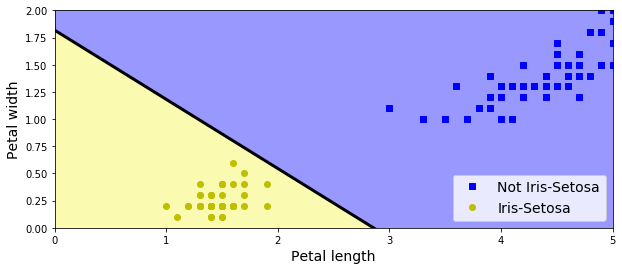

In [3]:
# Plot classification result
#---------------------------
%matplotlib inline
import matplotlib.pyplot as plt

a      = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b      = -per_clf.intercept_ / per_clf.coef_[0][1]
axes   = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new     = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz        = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

#save_fig("perceptron_iris_plot")
plt.show()

El **algoritmo de aprendizaje** de Perceptron se parece mucho al **SGD**. De hecho, la clase de *Perceptron* de Scikit-Learn es equivalente a usar *SGDClassifier* con los siguientes hiperparámetros: 
- *loss*          = "perceptron", 
- *learning_rate* = "constant", 
- *eta0*          = 1 (la tasa de aprendizaje) y 
- *penalty*       = "None" (sin regularización).

Tengamos en cuenta que, al **contrario de los clasificadores de regresión logística**, los perceptrones **no generan una probabilidad de clase; más bien, solo hacen predicciones basadas en un umbral difícil**. Esta es una de las buenas razones para preferir la Regresión logística sobre los Perceptrones.

## Funciones de activación

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

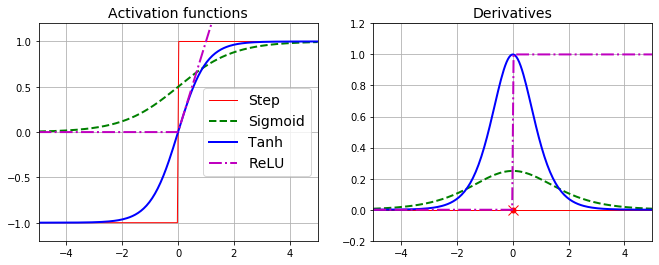

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("activation_functions_plot")
plt.show()

## Construyendo un clasificador de imágenes

Primero importemos TensorFlow y Keras.

In [12]:
!pip install tensorflow==2.0.0-alpha0
!pip install keras

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [11]:
import tensorflow as tf
from tensorflow import keras

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
tf.__version__

'2.0.0'

In [9]:
keras.__version__

'2.2.4-tf'

Comencemos cargando el conjunto de datos **Fashion MNIST**. Keras tiene una serie de funciones para cargar conjuntos de datos populares en *keras.datasets*. 
- El conjunto de datos ya está dividido entre un **conjunto de entrenamiento** y un **conjunto de prueba**, pero puede ser útil dividir aún más el conjunto de entrenamiento para tener un **conjunto de validación**:

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

El **conjunto de entrenamiento** contiene 60,000 imágenes en escala de grises, cada una de $28\times 28$ píxeles:

In [11]:
X_train_full.shape

(60000, 28, 28)

Cada intensidad de píxel se representa como un byte (0 a 255):

In [12]:
X_train_full.dtype

dtype('uint8')

Dividamos el **conjunto de entrenamiento** completo en un **conjunto de validación** y un conjunto de entrenamiento (*más pequeño*). También **escalamos las intensidades de píxeles hasta el rango 0-1** y las convertimos en flotantes, dividiéndolas por 255.

In [13]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Puede trazar una imagen usando la función *imshow()* de Matplotlib, con un mapa de color 'binario':

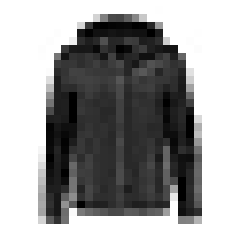

In [14]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Las etiquetas son los ID de clase (representados como *uint8*), de 0 a 9:

In [15]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Aquí están los nombres de clase correspondientes:

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Entonces, la primera imagen en el conjunto de entrenamiento es un abrigo:

In [17]:
class_names[y_train[0]]

'Coat'

El **conjunto de validación** contiene 5,000 imágenes, y el **conjunto de prueba** contiene 10,000 imágenes:

In [18]:
X_valid.shape

(5000, 28, 28)

In [19]:
X_test.shape

(10000, 28, 28)

Echemos un vistazo a una muestra de las imágenes en el conjunto de datos:

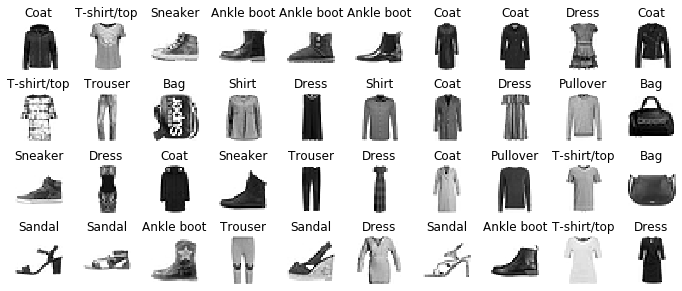

In [20]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Crear el modelo usando la API secuencial

¡Ahora construyamos la red neuronal! Aquí hay una clasificación MLP con dos capas ocultas:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Veamos este código línea por línea:
- La primera línea crea un modelo secuencial. Este es el tipo más simple de modelo Keras, para redes neuronales que están compuestas de una sola pila de capas, conectadas secuencialmente. Esto se llama la **API secuencial**.

- Luego, construimos la primera capa y la agregamos al modelo. Es una capa Flatten cuyo papel es simplemente convertir cada imagen de entrada en una matriz 1D. Alternativamente, puede agregar un keras.layers.InputLayer como la primera capa, estableciendo $shape = [28,28]$.

- A continuación, agregamos una capa oculta densa con 300 neuronas. Utilizará la función de activación ReLU. Cada capa densa gestiona su propia matriz de peso, que contiene todos los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de términos de sesgo (uno por neurona). 

- A continuación, agregamos una segunda capa oculta densa con 100 neuronas, que también utiliza la función de activación ReLU.

- Finalmente, agregamos una capa de salida densa con 10 neuronas (una por clase), usando la función de activación softmax (porque las clases son exclusivas).

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

En lugar de agregar las capas una por una como acabamos de hacer, puede **pasar una lista de capas al crear el modelo secuencial**:

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.layers

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


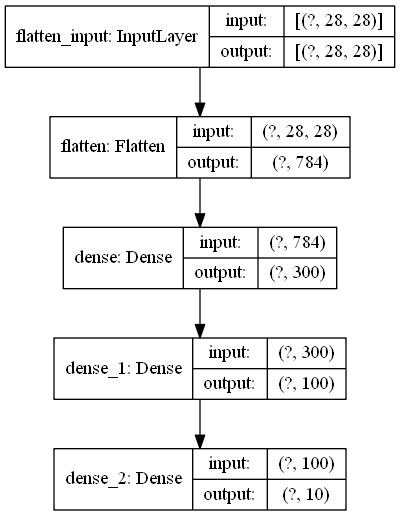

In [25]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [28]:
model.get_layer(hidden1.name) is hidden1

True

## Accediendo a los pesos y bias entrenados

In [29]:
weights, biases = hidden1.get_weights()

In [30]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

### Compilando el modelo
Después de crear un modelo, debe llamar a su método *compile()* para especificar la función de pérdida y el optimizador a utilizar. Opcionalmente, también puede especificar una lista de métricas adicionales para calcular durante el entrenamiento y la evaluación:

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Entrenando y evaluando el modelo
Ahora el modelo está listo para ser entrenado. Para esto, simplemente necesitamos llamar a su método *fit()*. 
- Le pasamos las características de entrada (X_train) y las clases de destino (y_train), así como la cantidad de épocas para entrenar (o de lo contrario, sería predeterminado a solo 1, lo que definitivamente no sería suficiente para converger en una buena solución). 
- También pasamos un conjunto de validación (esto es opcional): Keras medirá la pérdida y las métricas adicionales en este conjunto al final de cada época, lo cual es muy útil para ver qué tan bien se desempeña realmente el modelo.
- **NOTA:** si el rendimiento en el entrenamiento es mucho mejor que en el conjunto de validación, su modelo probablemente esté sobreajustando el conjunto de entrenamiento (o hay un error, como una falta de coincidencia de datos entre el conjunto de entrenamiento y el conjunto de validación):

In [35]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 21s 376us/sample - loss: 0.7228 - accuracy: 0.7622 - val_loss: 0.5310 - val_accuracy: 0.8148
Epoch 2/30
55000/55000 [==============================] - 12s 212us/sample - loss: 0.4839 - accuracy: 0.8320 - val_loss: 0.4491 - val_accuracy: 0.8452
Epoch 3/30
55000/55000 [==============================] - 12s 226us/sample - loss: 0.4380 - accuracy: 0.8470 - val_loss: 0.4177 - val_accuracy: 0.8556
Epoch 4/30
55000/55000 [==============================] - 14s 249us/sample - loss: 0.4128 - accuracy: 0.8557 - val_loss: 0.3904 - val_accuracy: 0.8656
Epoch 5/30
55000/55000 [==============================] - 14s 248us/sample - loss: 0.3929 - accuracy: 0.8625 - val_loss: 0.3985 - val_accuracy: 0.8612
Epoch 6/30
55000/55000 [==============================] - 13s 233us/sample - loss: 0.3776 - accuracy: 0.8672 - val_loss: 0.3731 - val_accuracy: 0.8740
Epoch 7/30
55000/55000 [=====================

Puede ver que la **pérdida de entrenamiento se redujo**, lo cual es una buena señal, y la precisión de validación alcanzó el $88.28\%$ después de 30 épocas, no muy lejos de la precisión del entrenamiento, por lo que no parece haber demasiado ajuste.

El método *fit()* devuelve un objeto **history** que contiene: 
1. los parámetros de entrenamiento (*history.params*), 
2. la lista de épocas por las que pasó (*history.epoch*) y, 
3. lo más importante, un diccionario (*history.history*) que contiene la pérdida y las métricas adicionales que midió al final de cada época en el conjunto de entrenamiento y en el conjunto de validación (si corresponde). 

In [36]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [37]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

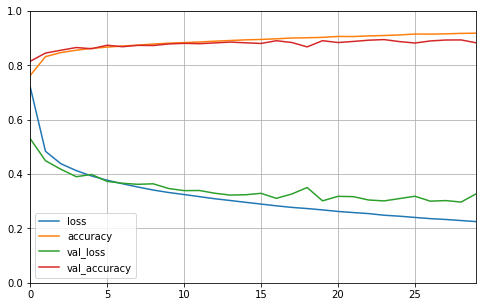

In [39]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

Una vez que esté **satisfecho con la precisión de validación de su modelo**, debe evaluarla en el *conjunto de prueba* para estimar el error de generalización antes de implementar el modelo en producción:

In [40]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36408724300861356, 0.869]

- Como vimos anteriormente, es **común obtener un rendimiento ligeramente inferior en el conjunto de prueba** que en el conjunto de validación, porque los hiperparámetros están sintonizados en el conjunto de validación, no en el conjunto de prueba (*sin embargo, en este ejemplo, no lo hicimos cualquier ajuste de hiperparámetro, por lo que la precisión más baja es solo mala suerte*).

## Usando el modelo para hacer predicciones
A continuación, podemos usar el método *predict()* del modelo para hacer predicciones sobre nuevas instancias. Como no tenemos instancias nuevas reales, solo usaremos las primeras 3 instancias del **conjunto de prueba**:

In [41]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [42]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [43]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [45]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

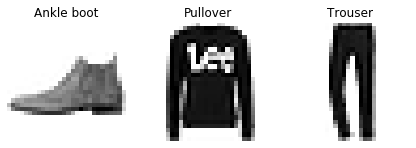

In [46]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Regresión MLP
Carguemos, dividamos y escalemos el conjunto de datos de vivienda de California:

In [47]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history  = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new    = X_test[:3]
y_pred   = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 4s 364us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5005 - val_

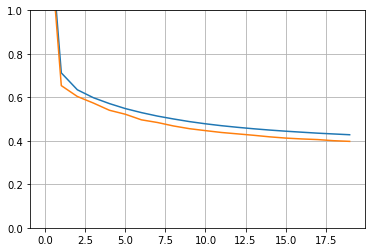

In [50]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [51]:
y_pred

array([[0.36892918],
       [1.6819053 ],
       [3.0886497 ]], dtype=float32)

Como puede ver, la API secuencial es **bastante fácil de usar**. Sin embargo, aunque los modelos secuenciales son extremadamente comunes, a veces es útil construir redes neuronales con topologías más complejas, o con múltiples entradas o salidas. Para este propósito, Keras ofrece la **API funcional**.